<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
!pip install torchgeo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
###############################################################################
# Imports
###############################################################################
import torch
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from pathlib import Path
import os
import time
import torchvision
import copy

import tempfile
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

###############################################################################
# Hyperparameters
###############################################################################

batch_size = 32
size = 512 # size of patches
length = 1024

on device: cuda


## Helper functions

In [4]:
###############################################################################
# Helper Functions
###############################################################################

def train_loop(model,
               train_dataloader,
               learning_rate = 0.03,
               optimizer=None, 
               scheduler=None):
  """ Trains model

  Parameters:
    model (torch.Module) -- model to train
    train_dataloader (torch.utils.data.DataLoader) -- dataloader to train on
    learning_rate (float) -- lr passed to default optimizer
    optimizer (torch.optim) -- optimizer to use during training
    scheduler (torch.optim.lr_scheduler) -- scheduler used to modify lr during training
  
  """
  
  loss_fn = nn.BCELoss()
  if optimizer is None:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  if scheduler is None:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=training_steps)

  model.train()

  # for i, (subvolumes, inklabels) in tqdm(enumerate(train_dataloader), total=training_steps):
  #     if i >= training_steps:
  #         break
  #     subvolumes, inklabels = subvolumes.to(device), inklabels.to(device)
      
  #     outputs = model(subvolumes)
  #     loss = loss_fn(outputs, inklabels)

  #     optimizer.zero_grad()
  #     loss.backward()
  #     optimizer.step()
  #     scheduler.step()

  #     if i % eval_interval == 0:
  #       train_loss = evaluate(model, train_dataloader)
  #       test_loss = evaluate(model, eval_dataloader)
  #       time_taken = (train_loss['time']+test_loss['time'])/2
  #       print(f"Train Loss: {train_loss['loss']} | Test Loss: {test_loss['loss']} | Time taken: {time_taken:.3f}")

In [5]:
def evaluate(model, data_loader, loss_fn):
  """ Trains model

  Parameters:
    model (torch.Module) -- model to train
    train_dataloader (torch.utils.data.DataLoader) -- dataloader to train on
    loss_fn (torch.nn) -- loss function to use for evaluation

  Returns a dict {'loss': loss(data_loader),
                  'time': time taken}
  """

  t = time.time()
  model.eval()
  with torch.inference_mode():
    losses = []
    for xb, yb in data_loader:
      xb, yb = xb.to(device), yb.to(device)
      outputs = model(xb)
      loss = loss_fn(outputs, yb)
      losses.append(loss.item())
      
  model.train()
  return {'loss': round(np.array(losses).mean(), 5),
          'time': round(time.time()-t, 3)}

## Download data and creating Dataloaders

In [6]:
# From https://github.com/microsoft/torchgeo/blob/main/docs/tutorials/getting_started.ipynb
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)
    
naip = NAIP(naip_root)
chesapeake_root = os.path.join(data_root, "chesapeake")
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

  0%|          | 0/513332284 [00:00<?, ?it/s]

  0%|          | 0/521985441 [00:00<?, ?it/s]

  0%|          | 0/489865657 [00:00<?, ?it/s]

  0%|          | 0/484476647 [00:00<?, ?it/s]

  0%|          | 0/287350495 [00:00<?, ?it/s]

In [7]:
dataset = naip & chesapeake
sampler = RandomGeoSampler(dataset, size=size, length = length)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size = batch_size)

torch.Size([32, 4, 512, 512]) torch.Size([32, 1, 512, 512])
Number of classes: 14


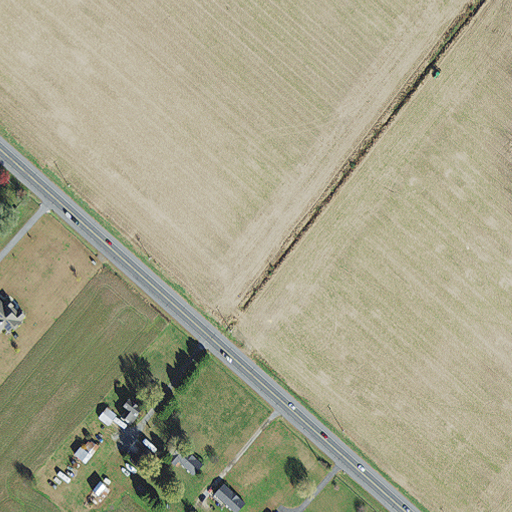

In [14]:
###############################################################################
# Exploratory data analysis
###############################################################################
# Displaying data we're working with
# I think the 4th dimension is cloud cover
sample = next(iter(dataloader))
image, target = sample["image"], sample["mask"]
print(image.shape, target.shape)
cmap_dict = {0: (0, 0, 0, 0), 1: (0, 197, 255, 255), 2: (0, 168, 132, 255), 3: (38, 115, 0, 255), 4: (76, 230, 0, 255), 5: (163, 255, 115, 255), 6: (255, 170, 0, 255), 7: (255, 0, 0, 255), 8: (156, 156, 156, 255), 9: (0, 0, 0, 255), 10: (115, 115, 0, 255), 11: (230, 230, 0, 255), 12: (255, 255, 115, 255), 13: (197, 0, 255, 255)}
converted = np.array([[cmap_dict[x] for x in row] for row in target[0][0].numpy()])
num_classes = len(cmap_dict.keys())
print(f"Number of classes: {num_classes}")

# img = PIL.Image.fromarray(np.uint8(image[0].permute(1, 2, 0).numpy()))
# plt.imshow(img)
# plt.show()
# img = PIL.Image.fromarray(np.uint8(image[0, :3].permute(1, 2, 0).numpy()))
# plt.imshow(img)
# plt.show()
# img = PIL.Image.fromarray(np.uint8(target[0][0].numpy()))
# plt.imshow(img)
# plt.show()

PIL.Image.fromarray(np.uint8(image[0].permute(1, 2, 0).numpy())).convert("RGB")

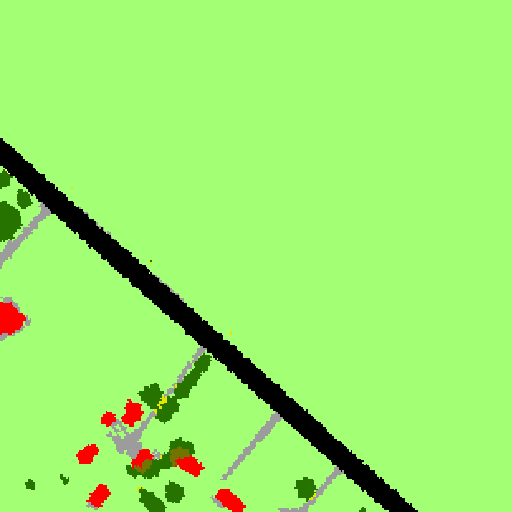

In [15]:
PIL.Image.fromarray(np.uint8(converted))

## Models

In [10]:
#Delete when using kaggle
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [27]:
###############################################################################
# Models
###############################################################################
num_classes = 14

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  Conv, ReLU, Conv, ReLU, Maxpool
  """

  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU())
    
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.
    
    Return (x, skip_connection)
    x will be used as the input to the next downsizing block,
    skip_connection will be used as the input to the residual connection
    """
    skip_connection = self.conv2(self.conv1(x))
    return self.max_pool(skip_connection), skip_connection

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Conv, ReLU, Conv, ReLU, Maxpool
  """

  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_channels=input_channels, out_channels=input_channels//2, kernel_size=3, stride=1, padding=0))

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU())

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.
    
    Return x
    x will be used as the input to the next upsizing block (or final layer),
    """
    print("-------------------")
    print(x.shape)
    x = self.up_sample(x)
    print(x.shape)

    crop_length = (res.shape[2]-x.shape[2])//2
    print()
    print(x.shape, res.shape, crop_length)
    print(res[:, :, crop_length:-crop_length, crop_length:-crop_length].shape)
    x = torch.concat((x, res[:, :, crop_length:-crop_length, crop_length:-crop_length]), dim = 1)
    print(x.shape)
    x = self.conv2(self.conv1(x))
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 4):
    super().__init__()
    downsize_channels = [(channels_in, 64), (64, 128), (128, 256), (256, 512)]
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c1, c2) for c1, c2 in downsize_channels])
    self.middle_layer = nn.Sequential(
        nn.Conv2d(in_channels=downsize_channels[-1][1], out_channels=2*downsize_channels[-1][1], kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=2*downsize_channels[-1][1], out_channels=2*downsize_channels[-1][1], kernel_size=3, stride=1, padding=0),
        nn.ReLU())

    upsize_channels = [(1024, 512), (512, 256), (256, 128), (128, 64)]
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(c1, c2) for c1, c2 in upsize_channels])

    self.final_layer = nn.Conv2d(in_channels=upsize_channels[-1][1], out_channels=num_classes, kernel_size=1, stride=1, padding=0)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    residuals = []
    for downsample in self.downsample_blocks:
      x, res = downsample(x)
      residuals.append(res)

    x = self.middle_layer(x)

    for i, upsample in enumerate(self.upsample_blocks):
      x = upsample(x, residuals[-(i+1)])

    x = self.final_layer(x)
    x = x.permute(0, 2, 3, 1)
    return x

"""
Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.
"""

xb = torch.rand((2, 4, 512, 512)).to(device)
model = UNET().to(device)
model(xb).shape


OutOfMemoryError: ignored

In [ ]:
summary(model, input_size=[10, 4, 572, 572], col_names =['input_size', 'output_size', 'num_params', 'trainable'])

In [39]:
#torch.Size([10, 1024, 48, 48]) torch.Size([10, 512, 56, 56])
# a = shape[2]


torch.Size([10, 512, 48, 48])